In [1]:
%matplotlib notebook
%load_ext autoreload
%pwd

'/ocean/projects/asc170022p/mtragoza/lung-project/notebooks'

In [3]:
import sys, os
os.environ['PKG_CONFIG_PATH'] = '/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/pkgconfig'

import numpy as np
import skimage
import torch
import nibabel as nib

from totalsegmentator.python_api import totalsegmentator
from totalsegmentator.libs import combine_masks

import pygalmesh
import meshio

sys.path.append('..')
import project

torch.cuda.is_available()

True

In [4]:
%autoreload
emory4dct = project.imaging.Emory4DCT('../data/Emory-4DCT')
emory4dct

Emory4DCT('../data/Emory-4DCT', 10 cases)

In [25]:
def select_regions_by_size(mask, which=slice(1, 3)):
    regions = skimage.measure.label(mask)
    region_sizes = np.unique(regions, return_counts=True)[1]
    selected_regions = np.argsort(-region_sizes)[which]
    return np.isin(regions, selected_regions).astype(mask.dtype)

mask = np.array([
    [1, 1, 0, 1, 1],
    [1, 1, 0, 1, 1],
    [1, 1, 0, 1, 1],
    [0, 0, 0, 0, 0],
    [1, 0, 0, 1, 1],
])
select_regions_by_size(mask)

array([[1, 1, 0, 1, 1],
       [1, 1, 0, 1, 1],
       [1, 1, 0, 1, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [26]:
%%time

for case in emory4dct.cases:
    for phase in emory4dct.phases:
        print(f'Segmenting {case.case_name} phase {phase}')
        
        image_file = case.nifti_file(phase=phase)
        mask_file = case.mask_file(phase=phase, roi='lung_combined_mask')
        mask_dir = mask_file.parent
        
        totalsegmentator(
            input=image_file,
            output=mask_dir,
            task='total',
            roi_subset=[
                'lung_upper_lobe_right',
                'lung_middle_lobe_right',
                'lung_lower_lobe_right',
                'lung_upper_lobe_left',
                'lung_lower_lobe_left'
            ],
        )
        totalsegmentator(
            input=image_file,
            output=mask_dir,
            task='lung_vessels'
        )
        totalsegmentator(
            input=image_file,
            output=mask_dir,
            task='body'
        )
        mask_nii = combine_masks(
            mask_dir=mask_dir,
            class_type='lung'
        )

        # select only the largest connected regions
        mask_data = mask_nii.get_fdata()
        new_mask_data = select_regions_by_size(mask_data)
        new_mask_nii = nib.nifti1.Nifti1Image(new_mask_data, mask_nii.affine)        
        
        nib.save(new_mask_nii, mask_file)

Segmenting Case1Pack phase 0

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.22s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 97.76it/s]


  Predicted in 7.08s
Resampling...
  cropping from (256, 256, 94) to (256, 193, 94)
Resampling...
  Resampled in 1.16s
Predicting part 1 of 1 ...


100%|██████████| 4/4 [00:00<00:00, 175.24it/s]


  Predicted in 8.52s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.52s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.22s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 93.54it/s]


  Predicted in 7.01s
Resampling...
  cropping from (256, 256, 94) to (256, 193, 94)
Predicting...


100%|██████████| 48/48 [00:02<00:00, 18.28it/s]


  Predicted in 19.94s
Saving segmentations...
Creating lung_vessels.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]


Creating lung_trachea_bronchia.nii.gz
  Saved in 0.46s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 1.58s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 8/8 [00:00<00:00, 33.39it/s]


  Predicted in 8.49s


100%|██████████| 1/1 [00:00<00:00, 17.53it/s]

Resampling...


Saving segmentations...
Creating body_trunc.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

Creating body_extremities.nii.gz
  Saved in 158.95s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case1Pack phase 10

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.22s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 79.40it/s]


  Predicted in 7.49s
Resampling...
  cropping from (256, 256, 94) to (256, 193, 94)
Resampling...
  Resampled in 1.16s
Predicting part 1 of 1 ...


100%|██████████| 4/4 [00:00<00:00, 174.47it/s]


  Predicted in 8.70s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.56s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.23s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 111.20it/s]


  Predicted in 7.17s
Resampling...
  cropping from (256, 256, 94) to (256, 193, 94)
Predicting...


100%|██████████| 48/48 [00:02<00:00, 18.27it/s]


  Predicted in 19.99s
Saving segmentations...
Creating lung_vessels.nii.gz

Creating lung_trachea_bronchia.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.50s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 1.59s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 8/8 [00:00<00:00, 34.53it/s]


  Predicted in 8.57s


100%|██████████| 1/1 [00:00<00:00, 18.41it/s]

Resampling...


Saving segmentations...
Creating body_trunc.nii.gzCreating body_extremities.nii.gz



  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.37s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case1Pack phase 20

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.22s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 97.34it/s]


  Predicted in 7.14s
Resampling...
  cropping from (256, 256, 94) to (256, 193, 94)
Resampling...
  Resampled in 1.16s
Predicting part 1 of 1 ...


100%|██████████| 4/4 [00:00<00:00, 171.48it/s]


  Predicted in 8.58s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 1.27s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.22s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 98.19it/s]


  Predicted in 7.16s
Resampling...
  cropping from (256, 256, 94) to (256, 193, 94)
Predicting...


100%|██████████| 48/48 [00:02<00:00, 18.22it/s]


  Predicted in 19.88s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.45s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 1.57s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 8/8 [00:00<00:00, 34.37it/s]


  Predicted in 8.45s


100%|██████████| 1/1 [00:00<00:00, 17.46it/s]

Resampling...


Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.36s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case1Pack phase 30

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.22s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 85.85it/s]


  Predicted in 7.18s
Resampling...
  cropping from (256, 256, 94) to (256, 193, 94)
Resampling...
  Resampled in 1.15s
Predicting part 1 of 1 ...


100%|██████████| 4/4 [00:00<00:00, 172.03it/s]


  Predicted in 8.36s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.58s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.23s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 105.29it/s]


  Predicted in 7.20s
Resampling...
  cropping from (256, 256, 94) to (256, 193, 94)
Predicting...


100%|██████████| 48/48 [00:02<00:00, 18.28it/s]


  Predicted in 19.89s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.45s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 1.58s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 8/8 [00:00<00:00, 34.06it/s]


  Predicted in 8.47s


100%|██████████| 1/1 [00:00<00:00, 17.30it/s]

Resampling...


Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.38s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case1Pack phase 40

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.22s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 78.49it/s]


  Predicted in 7.19s
Resampling...
  cropping from (256, 256, 94) to (256, 193, 94)
Resampling...
  Resampled in 1.15s
Predicting part 1 of 1 ...


100%|██████████| 4/4 [00:00<00:00, 173.72it/s]


  Predicted in 8.57s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.55s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.22s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 82.01it/s]


  Predicted in 7.28s
Resampling...
  cropping from (256, 256, 94) to (256, 193, 94)
Predicting...


100%|██████████| 48/48 [00:02<00:00, 18.25it/s]


  Predicted in 19.90s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.45s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 1.58s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 8/8 [00:00<00:00, 34.35it/s]


  Predicted in 8.55s


100%|██████████| 1/1 [00:00<00:00, 17.14it/s]

Resampling...


Saving segmentations...
Creating body_trunc.nii.gz

Creating body_extremities.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.32s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case1Pack phase 50

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.22s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 96.64it/s]


  Predicted in 7.19s
Resampling...
  cropping from (256, 256, 94) to (256, 193, 94)
Resampling...
  Resampled in 1.16s
Predicting part 1 of 1 ...


100%|██████████| 4/4 [00:00<00:00, 171.01it/s]


  Predicted in 8.74s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.65s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.22s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 83.63it/s]


  Predicted in 7.37s
Resampling...
  cropping from (256, 256, 94) to (256, 193, 94)
Predicting...


100%|██████████| 48/48 [00:02<00:00, 18.26it/s]


  Predicted in 19.88s
Saving segmentations...
Creating lung_vessels.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

Creating lung_trachea_bronchia.nii.gz
  Saved in 0.46s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 1.57s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 8/8 [00:00<00:00, 33.77it/s]


  Predicted in 8.52s


100%|██████████| 1/1 [00:00<00:00, 17.71it/s]

Resampling...


Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.34s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case1Pack phase 60

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.22s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 86.48it/s]


  Predicted in 7.20s
Resampling...
  cropping from (256, 256, 94) to (256, 193, 94)
Resampling...
  Resampled in 1.16s
Predicting part 1 of 1 ...


100%|██████████| 4/4 [00:00<00:00, 169.84it/s]


  Predicted in 8.49s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.54s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.22s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 85.50it/s]


  Predicted in 7.08s
Resampling...
  cropping from (256, 256, 94) to (256, 193, 94)
Predicting...


100%|██████████| 48/48 [00:02<00:00, 18.24it/s]


  Predicted in 19.96s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.50s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 1.57s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 8/8 [00:00<00:00, 33.97it/s]


  Predicted in 8.49s


100%|██████████| 1/1 [00:00<00:00, 17.52it/s]

Resampling...


Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.48s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case1Pack phase 70

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.22s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 95.49it/s]


  Predicted in 7.10s
Resampling...
  cropping from (256, 256, 94) to (256, 193, 94)
Resampling...
  Resampled in 1.15s
Predicting part 1 of 1 ...


100%|██████████| 4/4 [00:00<00:00, 171.18it/s]


  Predicted in 8.68s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.55s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.22s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 93.14it/s]


  Predicted in 7.09s
Resampling...
  cropping from (256, 256, 94) to (256, 193, 94)
Predicting...


100%|██████████| 48/48 [00:02<00:00, 18.23it/s]


  Predicted in 19.90s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.47s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 1.57s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 8/8 [00:00<00:00, 34.26it/s]


  Predicted in 8.65s


100%|██████████| 1/1 [00:00<00:00, 17.61it/s]

Resampling...


Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.33s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case1Pack phase 80

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.22s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 102.73it/s]


  Predicted in 7.23s
Resampling...
  cropping from (256, 256, 94) to (256, 193, 94)
Resampling...
  Resampled in 1.16s
Predicting part 1 of 1 ...


100%|██████████| 4/4 [00:00<00:00, 169.63it/s]


  Predicted in 8.53s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.58s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.22s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 109.10it/s]


  Predicted in 7.25s
Resampling...
  cropping from (256, 256, 94) to (256, 193, 94)
Predicting...


100%|██████████| 48/48 [00:02<00:00, 18.27it/s]


  Predicted in 19.93s
Saving segmentations...
Creating lung_vessels.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]


Creating lung_trachea_bronchia.nii.gz
  Saved in 0.51s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 1.57s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 8/8 [00:00<00:00, 33.91it/s]


  Predicted in 8.65s


100%|██████████| 1/1 [00:00<00:00, 17.66it/s]

Resampling...


Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]


  Saved in 0.32s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case1Pack phase 90

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.22s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 106.30it/s]


  Predicted in 7.17s
Resampling...
  cropping from (256, 256, 94) to (256, 193, 94)
Resampling...
  Resampled in 1.15s
Predicting part 1 of 1 ...


100%|██████████| 4/4 [00:00<00:00, 171.04it/s]


  Predicted in 8.68s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.56s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.22s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 107.13it/s]


  Predicted in 7.11s
Resampling...
  cropping from (256, 256, 94) to (256, 193, 94)
Predicting...


100%|██████████| 48/48 [00:02<00:00, 18.24it/s]


  Predicted in 20.01s
Saving segmentations...


  0%|          | 0/2 [00:00<?, ?it/s]

Creating lung_vessels.nii.gzCreating lung_trachea_bronchia.nii.gz

  Saved in 0.55s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 1.58s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 8/8 [00:00<00:00, 33.13it/s]


  Predicted in 8.73s


100%|██████████| 1/1 [00:00<00:00, 17.17it/s]

Resampling...


Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]


  Saved in 0.36s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case2Pack phase 0

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.24s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 82.23it/s]


  Predicted in 7.33s
Resampling...
  cropping from (256, 256, 94) to (256, 204, 94)
Resampling...
  Resampled in 1.97s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 32.13it/s]


  Predicted in 9.63s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.55s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.24s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 81.67it/s]


  Predicted in 7.21s
Resampling...
  cropping from (256, 256, 94) to (256, 204, 94)
Predicting...


100%|██████████| 80/80 [00:04<00:00, 17.64it/s]


  Predicted in 28.31s
Saving segmentations...
Creating lung_vessels.nii.gz



  0%|          | 0/2 [00:00<?, ?it/s]

Creating lung_trachea_bronchia.nii.gz  Saved in 0.46s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.53s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 18/18 [00:00<00:00, 23.05it/s]


  Predicted in 9.80s


100%|██████████| 1/1 [00:00<00:00,  8.29it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.40s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case2Pack phase 10

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.24s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 80.31it/s]


  Predicted in 7.19s
Resampling...
  cropping from (256, 256, 94) to (256, 204, 94)
Resampling...
  Resampled in 1.97s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 32.66it/s]


  Predicted in 9.58s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.57s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.24s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 111.22it/s]


  Predicted in 7.25s
Resampling...
  cropping from (256, 256, 94) to (256, 204, 94)
Predicting...


100%|██████████| 80/80 [00:04<00:00, 17.63it/s]


  Predicted in 28.16s
Saving segmentations...
Creating lung_vessels.nii.gz

Creating lung_trachea_bronchia.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.47s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.53s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 18/18 [00:00<00:00, 23.13it/s]


  Predicted in 9.70s


100%|██████████| 1/1 [00:00<00:00,  8.15it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.36s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case2Pack phase 20

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.24s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 109.39it/s]


  Predicted in 7.15s
Resampling...
  cropping from (256, 256, 94) to (256, 204, 94)
Resampling...
  Resampled in 1.97s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 32.16it/s]


  Predicted in 9.43s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.75s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.24s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 106.43it/s]


  Predicted in 7.18s
Resampling...
  cropping from (256, 256, 94) to (256, 204, 94)
Predicting...


100%|██████████| 80/80 [00:04<00:00, 17.63it/s]


  Predicted in 28.43s
Saving segmentations...


  0%|          | 0/2 [00:00<?, ?it/s]

Creating lung_trachea_bronchia.nii.gzCreating lung_vessels.nii.gz

  Saved in 0.53s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.52s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 18/18 [00:00<00:00, 22.85it/s]


  Predicted in 9.65s


100%|██████████| 1/1 [00:00<00:00,  8.04it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.34s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case2Pack phase 30

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.24s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 86.31it/s]


  Predicted in 7.06s
Resampling...
  cropping from (256, 256, 94) to (256, 204, 94)
Resampling...
  Resampled in 1.97s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 32.68it/s]


  Predicted in 9.70s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.58s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.25s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 91.51it/s]


  Predicted in 7.45s
Resampling...
  cropping from (256, 256, 94) to (256, 204, 94)
Predicting...


100%|██████████| 80/80 [00:04<00:00, 17.61it/s]


  Predicted in 28.22s
Saving segmentations...


  0%|          | 0/2 [00:00<?, ?it/s]

Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz
  Saved in 31.81s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.52s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 18/18 [00:00<00:00, 22.95it/s]


  Predicted in 11.24s


100%|██████████| 1/1 [00:00<00:00,  8.22it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz

Creating body_extremities.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.33s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case2Pack phase 40

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.24s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 109.79it/s]


  Predicted in 10.10s
Resampling...
  cropping from (256, 256, 94) to (256, 204, 94)
Resampling...
  Resampled in 1.97s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 32.96it/s]


  Predicted in 9.55s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 1.33s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.24s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 110.09it/s]


  Predicted in 7.18s
Resampling...
  cropping from (256, 256, 94) to (256, 204, 94)
Predicting...


100%|██████████| 80/80 [00:04<00:00, 17.68it/s]


  Predicted in 28.15s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.88s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.53s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 18/18 [00:00<00:00, 22.82it/s]


  Predicted in 9.55s


100%|██████████| 1/1 [00:00<00:00,  8.20it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]


  Saved in 0.36s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case2Pack phase 50

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.24s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 106.75it/s]


  Predicted in 7.32s
Resampling...
  cropping from (256, 256, 94) to (256, 204, 94)
Resampling...
  Resampled in 1.97s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 32.93it/s]


  Predicted in 9.47s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.56s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.25s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 105.73it/s]


  Predicted in 7.27s
Resampling...
  cropping from (256, 256, 94) to (256, 204, 94)
Predicting...


100%|██████████| 80/80 [00:04<00:00, 17.65it/s]


  Predicted in 28.17s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.49s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.53s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 18/18 [00:00<00:00, 23.24it/s]


  Predicted in 9.62s


100%|██████████| 1/1 [00:00<00:00,  8.22it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.32s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case2Pack phase 60

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.24s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 92.08it/s]


  Predicted in 7.19s
Resampling...
  cropping from (256, 256, 94) to (256, 204, 94)
Resampling...
  Resampled in 1.97s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 32.04it/s]


  Predicted in 9.54s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.60s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.24s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 97.42it/s]


  Predicted in 7.11s
Resampling...
  cropping from (256, 256, 94) to (256, 204, 94)
Predicting...


100%|██████████| 80/80 [00:04<00:00, 17.67it/s]


  Predicted in 28.23s
Saving segmentations...
Creating lung_vessels.nii.gz

Creating lung_trachea_bronchia.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.49s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.53s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 18/18 [00:00<00:00, 23.12it/s]


  Predicted in 9.64s


100%|██████████| 1/1 [00:00<00:00,  8.07it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.33s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case2Pack phase 70

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.24s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 75.96it/s]


  Predicted in 7.16s
Resampling...
  cropping from (256, 256, 94) to (256, 204, 94)
Resampling...
  Resampled in 1.97s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 32.12it/s]


  Predicted in 9.67s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.55s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.24s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 106.09it/s]


  Predicted in 7.29s
Resampling...
  cropping from (256, 256, 94) to (256, 204, 94)
Predicting...


100%|██████████| 80/80 [00:04<00:00, 17.66it/s]


  Predicted in 28.28s
Saving segmentations...
Creating lung_vessels.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]


Creating lung_trachea_bronchia.nii.gz
  Saved in 13.93s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.53s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 18/18 [00:00<00:00, 22.80it/s]


  Predicted in 9.53s


100%|██████████| 1/1 [00:00<00:00,  8.09it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.34s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case2Pack phase 80

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.24s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 81.83it/s]


  Predicted in 7.29s
Resampling...
  cropping from (256, 256, 94) to (256, 204, 92)
Resampling...
  Resampled in 1.93s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 32.49it/s]


  Predicted in 9.64s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.56s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.24s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 81.82it/s]


  Predicted in 7.13s
Resampling...
  cropping from (256, 256, 94) to (256, 204, 92)
Predicting...


100%|██████████| 80/80 [00:04<00:00, 17.65it/s]


  Predicted in 30.54s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]


  Saved in 0.49s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.53s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 18/18 [00:00<00:00, 23.07it/s]


  Predicted in 9.82s


100%|██████████| 1/1 [00:00<00:00,  8.02it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.33s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case2Pack phase 90

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.24s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 93.54it/s]


  Predicted in 7.22s
Resampling...
  cropping from (256, 256, 94) to (256, 204, 92)
Resampling...
  Resampled in 1.92s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 33.09it/s]


  Predicted in 9.67s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.58s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.24s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 109.65it/s]


  Predicted in 7.18s
Resampling...
  cropping from (256, 256, 94) to (256, 204, 92)
Predicting...


100%|██████████| 80/80 [00:04<00:00, 17.64it/s]


  Predicted in 28.06s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.49s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.53s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 18/18 [00:00<00:00, 23.19it/s]


  Predicted in 10.10s


100%|██████████| 1/1 [00:00<00:00,  8.06it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 249.74s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case3Pack phase 0

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.23s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


  Predicted in 10.35s
Resampling...
  cropping from (256, 256, 94) to (256, 206, 94)
Resampling...
  Resampled in 1.66s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 23.02it/s]


  Predicted in 9.25s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.65s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.24s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 106.62it/s]


  Predicted in 7.24s
Resampling...
  cropping from (256, 256, 94) to (256, 206, 94)
Predicting...


100%|██████████| 80/80 [00:04<00:00, 17.68it/s]


  Predicted in 25.46s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]


  Saved in 0.48s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.06s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 8/8 [00:00<00:00, 33.89it/s]


  Predicted in 8.61s


100%|██████████| 1/1 [00:00<00:00, 10.58it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]


Creating body_extremities.nii.gz
  Saved in 0.33s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case3Pack phase 10

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.23s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 95.50it/s]


  Predicted in 7.04s
Resampling...
  cropping from (256, 256, 94) to (256, 206, 94)
Resampling...
  Resampled in 1.62s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 32.78it/s]


  Predicted in 9.08s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.70s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.23s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 109.80it/s]


  Predicted in 7.20s
Resampling...
  cropping from (256, 256, 94) to (256, 206, 94)
Predicting...


100%|██████████| 80/80 [00:04<00:00, 17.68it/s]


  Predicted in 25.62s
Saving segmentations...
Creating lung_vessels.nii.gz

Creating lung_trachea_bronchia.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.50s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.05s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 8/8 [00:00<00:00, 33.23it/s]


  Predicted in 8.87s


100%|██████████| 1/1 [00:00<00:00, 10.42it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.34s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case3Pack phase 20

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.23s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 85.05it/s]


  Predicted in 7.09s
Resampling...
  cropping from (256, 256, 94) to (256, 206, 93)
Resampling...
  Resampled in 1.60s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 32.74it/s]


  Predicted in 9.12s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.55s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.23s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 50.42it/s]


  Predicted in 7.27s
Resampling...
  cropping from (256, 256, 94) to (256, 206, 93)
Predicting...


100%|██████████| 80/80 [00:04<00:00, 17.62it/s]


  Predicted in 25.27s
Saving segmentations...
Creating lung_vessels.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]

Creating lung_trachea_bronchia.nii.gz

  Saved in 0.48s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.04s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 8/8 [00:00<00:00, 33.86it/s]


  Predicted in 8.88s


100%|██████████| 1/1 [00:00<00:00, 10.61it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.91s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case3Pack phase 30

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.23s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 89.76it/s]


  Predicted in 6.99s
Resampling...
  cropping from (256, 256, 94) to (256, 206, 93)
Resampling...
  Resampled in 1.60s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 33.28it/s]


  Predicted in 9.27s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.64s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.23s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 109.86it/s]


  Predicted in 7.21s
Resampling...
  cropping from (256, 256, 94) to (256, 206, 93)
Predicting...


100%|██████████| 80/80 [00:04<00:00, 17.63it/s]


  Predicted in 25.44s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.68s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.05s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 8/8 [00:00<00:00, 33.27it/s]


  Predicted in 8.70s


100%|██████████| 1/1 [00:00<00:00, 10.69it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.37s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case3Pack phase 40

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.23s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 106.89it/s]


  Predicted in 7.10s
Resampling...
  cropping from (256, 256, 94) to (256, 206, 94)
Resampling...
  Resampled in 1.64s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 32.72it/s]


  Predicted in 9.05s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.60s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.23s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 110.14it/s]


  Predicted in 7.23s
Resampling...
  cropping from (256, 256, 94) to (256, 206, 94)
Predicting...


100%|██████████| 80/80 [00:04<00:00, 17.63it/s]


  Predicted in 25.48s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]


  Saved in 0.48s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.04s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 8/8 [00:00<00:00, 34.05it/s]


  Predicted in 8.83s


100%|██████████| 1/1 [00:00<00:00, 10.19it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.38s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case3Pack phase 50

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.23s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 96.92it/s]


  Predicted in 7.01s
Resampling...
  cropping from (256, 256, 94) to (256, 206, 94)
Resampling...
  Resampled in 1.63s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 33.25it/s]


  Predicted in 9.08s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.58s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.24s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 109.28it/s]


  Predicted in 7.18s
Resampling...
  cropping from (256, 256, 94) to (256, 206, 94)
Predicting...


100%|██████████| 80/80 [00:04<00:00, 17.63it/s]


  Predicted in 25.38s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.58s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.06s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 8/8 [00:00<00:00, 34.04it/s]


  Predicted in 8.53s


100%|██████████| 1/1 [00:00<00:00, 10.47it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

Creating body_extremities.nii.gz
  Saved in 1.84s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case3Pack phase 60

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.23s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 108.84it/s]


  Predicted in 7.16s
Resampling...
  cropping from (256, 256, 94) to (256, 206, 93)
Resampling...
  Resampled in 1.60s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 32.99it/s]


  Predicted in 9.04s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 1.03s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.24s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 108.08it/s]


  Predicted in 8.15s
Resampling...
  cropping from (256, 256, 94) to (256, 206, 93)
Predicting...


100%|██████████| 80/80 [00:04<00:00, 17.64it/s]


  Predicted in 25.44s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.52s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.05s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 8/8 [00:00<00:00, 33.74it/s]


  Predicted in 8.75s


100%|██████████| 1/1 [00:00<00:00, 11.06it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.34s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case3Pack phase 70

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.23s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 110.27it/s]


  Predicted in 7.21s
Resampling...
  cropping from (256, 256, 94) to (256, 206, 93)
Resampling...
  Resampled in 1.61s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 32.63it/s]


  Predicted in 9.09s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.67s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.23s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 74.44it/s]


  Predicted in 7.23s
Resampling...
  cropping from (256, 256, 94) to (256, 206, 93)
Predicting...


100%|██████████| 80/80 [00:04<00:00, 17.64it/s]


  Predicted in 25.39s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]


  Saved in 0.60s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.05s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 8/8 [00:00<00:00, 34.74it/s]


  Predicted in 8.88s


100%|██████████| 1/1 [00:00<00:00, 10.43it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz

Creating body_extremities.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.33s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case3Pack phase 80

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.23s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 102.80it/s]


  Predicted in 7.18s
Resampling...
  cropping from (256, 256, 94) to (256, 200, 93)
Resampling...
  Resampled in 1.55s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 32.68it/s]


  Predicted in 8.89s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.63s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.23s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 109.56it/s]


  Predicted in 7.15s
Resampling...
  cropping from (256, 256, 94) to (256, 200, 93)
Predicting...


100%|██████████| 64/64 [00:03<00:00, 17.83it/s]


  Predicted in 24.02s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 31.37s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.05s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 8/8 [00:00<00:00, 34.24it/s]


  Predicted in 8.91s


100%|██████████| 1/1 [00:00<00:00, 10.67it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]


Creating body_extremities.nii.gz
  Saved in 0.40s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case3Pack phase 90

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.23s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 97.61it/s]


  Predicted in 7.28s
Resampling...
  cropping from (256, 256, 94) to (256, 206, 93)
Resampling...
  Resampled in 1.60s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 31.89it/s]


  Predicted in 9.19s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.57s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.24s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 95.61it/s]


  Predicted in 7.14s
Resampling...
  cropping from (256, 256, 94) to (256, 206, 93)
Predicting...


100%|██████████| 80/80 [00:04<00:00, 17.65it/s]


  Predicted in 25.48s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.51s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.05s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 8/8 [00:00<00:00, 33.28it/s]


  Predicted in 8.64s


100%|██████████| 1/1 [00:00<00:00, 10.42it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]


  Saved in 0.35s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case4Pack phase 0

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.22s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 78.76it/s]


  Predicted in 7.08s
Resampling...
  cropping from (256, 256, 94) to (256, 216, 94)
Resampling...
  Resampled in 1.46s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 32.53it/s]


  Predicted in 9.12s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.59s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.22s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 109.97it/s]


  Predicted in 7.16s
Resampling...
  cropping from (256, 256, 94) to (256, 216, 94)
Predicting...


100%|██████████| 60/60 [00:03<00:00, 17.93it/s]


  Predicted in 23.36s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.53s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 1.76s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 8/8 [00:00<00:00, 33.27it/s]


  Predicted in 8.65s


100%|██████████| 1/1 [00:00<00:00, 15.12it/s]

Resampling...


Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.36s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case4Pack phase 10

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.22s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 104.77it/s]


  Predicted in 7.14s
Resampling...
  cropping from (256, 256, 94) to (256, 222, 94)
Resampling...
  Resampled in 1.50s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 32.28it/s]


  Predicted in 9.22s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 104.10s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.22s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 101.59it/s]


  Predicted in 7.07s
Resampling...
  cropping from (256, 256, 94) to (256, 222, 94)
Predicting...


100%|██████████| 60/60 [00:03<00:00, 17.96it/s]


  Predicted in 23.55s
Saving segmentations...
Creating lung_vessels.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

Creating lung_trachea_bronchia.nii.gz
  Saved in 0.53s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 1.76s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 8/8 [00:00<00:00, 33.71it/s]


  Predicted in 8.70s


100%|██████████| 1/1 [00:00<00:00, 15.16it/s]

Resampling...


Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]


  Saved in 0.41s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case4Pack phase 20

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.22s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 76.32it/s]


  Predicted in 6.95s
Resampling...
  cropping from (256, 256, 94) to (256, 222, 94)
Resampling...
  Resampled in 1.50s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 33.37it/s]


  Predicted in 8.90s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.66s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.22s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 95.26it/s]


  Predicted in 6.95s
Resampling...
  cropping from (256, 256, 94) to (256, 222, 94)
Predicting...


100%|██████████| 60/60 [00:03<00:00, 17.89it/s]


  Predicted in 23.84s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.51s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 1.76s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 8/8 [00:00<00:00, 33.72it/s]


  Predicted in 8.56s


100%|██████████| 1/1 [00:00<00:00, 15.08it/s]

Resampling...


Saving segmentations...
Creating body_trunc.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

Creating body_extremities.nii.gz
  Saved in 0.34s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case4Pack phase 30

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.23s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 110.49it/s]


  Predicted in 6.97s
Resampling...
  cropping from (256, 256, 94) to (256, 216, 94)
Resampling...
  Resampled in 1.48s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 33.02it/s]


  Predicted in 9.09s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.55s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.22s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 92.52it/s]


  Predicted in 7.03s
Resampling...
  cropping from (256, 256, 94) to (256, 216, 94)
Predicting...


100%|██████████| 60/60 [00:03<00:00, 17.92it/s]


  Predicted in 23.21s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.54s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 1.77s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 8/8 [00:00<00:00, 34.40it/s]


  Predicted in 8.48s


100%|██████████| 1/1 [00:00<00:00, 15.19it/s]

Resampling...


Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]


  Saved in 0.38s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case4Pack phase 40

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.23s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 62.90it/s]


  Predicted in 7.04s
Resampling...
  cropping from (256, 256, 94) to (256, 222, 94)
Resampling...
  Resampled in 1.51s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 33.04it/s]


  Predicted in 8.88s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.64s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.22s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 98.27it/s]


  Predicted in 7.03s
Resampling...
  cropping from (256, 256, 94) to (256, 222, 94)
Predicting...


100%|██████████| 60/60 [00:03<00:00, 17.88it/s]


  Predicted in 23.60s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.56s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 1.76s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 8/8 [00:00<00:00, 33.21it/s]


  Predicted in 8.71s


100%|██████████| 1/1 [00:00<00:00, 15.12it/s]

Resampling...


Saving segmentations...
Creating body_trunc.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

Creating body_extremities.nii.gz
  Saved in 0.39s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case4Pack phase 50

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.22s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 83.52it/s]


  Predicted in 7.06s
Resampling...
  cropping from (256, 256, 94) to (256, 222, 92)
Resampling...
  Resampled in 1.47s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 32.72it/s]


  Predicted in 9.04s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.60s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.22s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 106.75it/s]


  Predicted in 6.99s
Resampling...
  cropping from (256, 256, 94) to (256, 222, 92)
Predicting...


100%|██████████| 60/60 [00:03<00:00, 17.95it/s]


  Predicted in 23.26s
Saving segmentations...
Creating lung_vessels.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]


Creating lung_trachea_bronchia.nii.gz
  Saved in 0.63s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 1.76s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 8/8 [00:00<00:00, 33.23it/s]


  Predicted in 8.72s


100%|██████████| 1/1 [00:00<00:00, 15.24it/s]

Resampling...


Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]


  Saved in 0.44s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case4Pack phase 60

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.22s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 81.58it/s]


  Predicted in 6.94s
Resampling...
  cropping from (256, 256, 94) to (256, 222, 92)
Resampling...
  Resampled in 1.47s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 33.09it/s]


  Predicted in 9.06s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.62s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.22s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 105.97it/s]


  Predicted in 7.02s
Resampling...
  cropping from (256, 256, 94) to (256, 222, 92)
Predicting...


100%|██████████| 60/60 [00:03<00:00, 17.89it/s]


  Predicted in 23.22s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.52s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 1.76s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 8/8 [00:00<00:00, 33.26it/s]


  Predicted in 8.43s


100%|██████████| 1/1 [00:00<00:00, 14.98it/s]

Resampling...


Saving segmentations...
Creating body_trunc.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]


Creating body_extremities.nii.gz
  Saved in 168.01s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case4Pack phase 70

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.22s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 104.23it/s]


  Predicted in 7.17s
Resampling...
  cropping from (256, 256, 94) to (256, 222, 92)
Resampling...
  Resampled in 1.47s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 32.02it/s]


  Predicted in 8.86s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.76s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.22s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 94.78it/s]


  Predicted in 7.06s
Resampling...
  cropping from (256, 256, 94) to (256, 222, 92)
Predicting...


100%|██████████| 60/60 [00:03<00:00, 17.94it/s]


  Predicted in 23.35s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.53s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 1.77s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 8/8 [00:00<00:00, 33.26it/s]


  Predicted in 8.70s


100%|██████████| 1/1 [00:00<00:00, 15.09it/s]

Resampling...


Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.35s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case4Pack phase 80

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.23s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 91.34it/s]


  Predicted in 7.04s
Resampling...
  cropping from (256, 256, 94) to (256, 216, 94)
Resampling...
  Resampled in 1.47s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 33.24it/s]


  Predicted in 8.85s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.64s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.23s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 75.84it/s]


  Predicted in 7.05s
Resampling...
  cropping from (256, 256, 94) to (256, 216, 94)
Predicting...


100%|██████████| 60/60 [00:03<00:00, 17.90it/s]


  Predicted in 23.26s
Saving segmentations...
Creating lung_trachea_bronchia.nii.gzCreating lung_vessels.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]



  Saved in 0.48s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 1.77s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 8/8 [00:00<00:00, 34.61it/s]


  Predicted in 8.50s


100%|██████████| 1/1 [00:00<00:00, 15.00it/s]

Resampling...


Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]


  Saved in 187.43s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case4Pack phase 90

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.23s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 80.89it/s]


  Predicted in 7.50s
Resampling...
  cropping from (256, 256, 94) to (256, 216, 94)
Resampling...
  Resampled in 1.47s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 32.14it/s]


  Predicted in 9.24s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 369.56s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.23s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 95.00it/s]


  Predicted in 7.32s
Resampling...
  cropping from (256, 256, 94) to (256, 216, 94)
Predicting...


100%|██████████| 60/60 [00:03<00:00, 17.96it/s]


  Predicted in 23.63s
Saving segmentations...


  0%|          | 0/2 [00:00<?, ?it/s]

Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz
  Saved in 0.79s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 1.76s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 8/8 [00:00<00:00, 33.23it/s]


  Predicted in 8.79s


100%|██████████| 1/1 [00:00<00:00, 14.92it/s]

Resampling...


Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.33s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case5Pack phase 0

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.23s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 74.15it/s]


  Predicted in 7.22s
Resampling...
  cropping from (256, 256, 94) to (256, 207, 94)
Resampling...
  Resampled in 1.78s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 31.86it/s]


  Predicted in 9.44s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 197.68s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.24s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 91.90it/s]


  Predicted in 9.56s
Resampling...
  cropping from (256, 256, 94) to (256, 207, 94)
Predicting...


100%|██████████| 80/80 [00:04<00:00, 17.68it/s]


  Predicted in 26.36s
Saving segmentations...


  0%|          | 0/2 [00:00<?, ?it/s]

Creating lung_trachea_bronchia.nii.gzCreating lung_vessels.nii.gz

  Saved in 0.55s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.17s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 8/8 [00:00<00:00, 33.58it/s]


  Predicted in 8.96s


100%|██████████| 1/1 [00:00<00:00, 12.24it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.38s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case5Pack phase 10

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.23s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 77.04it/s]


  Predicted in 7.27s
Resampling...
  cropping from (256, 256, 94) to (256, 207, 94)
Resampling...
  Resampled in 1.72s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 31.91it/s]


  Predicted in 9.48s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.58s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.23s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 91.00it/s]


  Predicted in 7.37s
Resampling...
  cropping from (256, 256, 94) to (256, 207, 94)
Predicting...


100%|██████████| 80/80 [00:04<00:00, 17.67it/s]


  Predicted in 26.34s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.51s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.17s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 8/8 [00:00<00:00, 33.90it/s]


  Predicted in 9.65s


100%|██████████| 1/1 [00:00<00:00, 11.98it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz

Creating body_extremities.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.36s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case5Pack phase 20

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.23s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 82.99it/s]


  Predicted in 7.26s
Resampling...
  cropping from (256, 256, 94) to (256, 207, 93)
Resampling...
  Resampled in 1.70s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 32.11it/s]


  Predicted in 9.47s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.56s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.23s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 95.47it/s]


  Predicted in 7.21s
Resampling...
  cropping from (256, 256, 94) to (256, 207, 93)
Predicting...


100%|██████████| 80/80 [00:04<00:00, 17.61it/s]


  Predicted in 27.12s
Saving segmentations...


  0%|          | 0/2 [00:00<?, ?it/s]

Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz
  Saved in 0.51s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.16s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 8/8 [00:00<00:00, 33.73it/s]


  Predicted in 9.14s


100%|██████████| 1/1 [00:00<00:00, 12.25it/s]


Resampling...
Saving segmentations...


  0%|          | 0/2 [00:00<?, ?it/s]

Creating body_trunc.nii.gz
Creating body_extremities.nii.gz
  Saved in 1.99s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case5Pack phase 30

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.23s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 78.57it/s]


  Predicted in 7.21s
Resampling...
  cropping from (256, 256, 94) to (256, 207, 91)
Resampling...
  Resampled in 1.65s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 31.89it/s]


  Predicted in 9.36s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.64s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.23s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 48.30it/s]


  Predicted in 7.28s
Resampling...
  cropping from (256, 256, 94) to (256, 207, 91)
Predicting...


100%|██████████| 80/80 [00:04<00:00, 17.61it/s]


  Predicted in 25.97s
Saving segmentations...
Creating lung_vessels.nii.gz

Creating lung_trachea_bronchia.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.48s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.16s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 8/8 [00:00<00:00, 33.28it/s]


  Predicted in 9.04s


100%|██████████| 1/1 [00:00<00:00, 12.19it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.35s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case5Pack phase 40

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.23s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 105.37it/s]


  Predicted in 7.34s
Resampling...
  cropping from (256, 256, 94) to (256, 207, 91)
Resampling...
  Resampled in 1.66s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 32.89it/s]


  Predicted in 9.18s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.62s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.23s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 84.02it/s]


  Predicted in 7.16s
Resampling...
  cropping from (256, 256, 94) to (256, 207, 91)
Predicting...


100%|██████████| 80/80 [00:04<00:00, 17.62it/s]


  Predicted in 25.91s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]


  Saved in 0.46s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.17s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 8/8 [00:00<00:00, 34.31it/s]


  Predicted in 8.79s


100%|██████████| 1/1 [00:00<00:00, 12.45it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]


  Saved in 0.35s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case5Pack phase 50

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.23s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 108.37it/s]


  Predicted in 7.24s
Resampling...
  cropping from (256, 256, 94) to (256, 207, 91)
Resampling...
  Resampled in 1.66s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 32.37it/s]


  Predicted in 9.45s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.57s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.23s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 53.11it/s]


  Predicted in 7.50s
Resampling...
  cropping from (256, 256, 94) to (256, 207, 91)
Predicting...


100%|██████████| 80/80 [00:04<00:00, 17.60it/s]


  Predicted in 25.86s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.51s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.16s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 8/8 [00:00<00:00, 33.65it/s]


  Predicted in 9.06s


100%|██████████| 1/1 [00:00<00:00, 12.22it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]


  Saved in 0.37s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case5Pack phase 60

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.24s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 97.71it/s]


  Predicted in 7.25s
Resampling...
  cropping from (256, 256, 94) to (256, 202, 91)
Resampling...
  Resampled in 1.62s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 32.21it/s]


  Predicted in 9.23s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.55s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.23s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 107.70it/s]


  Predicted in 7.28s
Resampling...
  cropping from (256, 256, 94) to (256, 202, 91)
Predicting...


100%|██████████| 80/80 [00:04<00:00, 17.62it/s]


  Predicted in 25.53s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]


  Saved in 0.46s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.16s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 8/8 [00:00<00:00, 33.20it/s]


  Predicted in 8.69s


100%|██████████| 1/1 [00:00<00:00, 12.46it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.36s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case5Pack phase 70

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.23s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 93.91it/s]


  Predicted in 7.21s
Resampling...
  cropping from (256, 256, 94) to (256, 207, 93)
Resampling...
  Resampled in 1.69s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 32.02it/s]


  Predicted in 9.30s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.57s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.23s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 105.55it/s]


  Predicted in 7.28s
Resampling...
  cropping from (256, 256, 94) to (256, 207, 93)
Predicting...


100%|██████████| 80/80 [00:04<00:00, 17.64it/s]


  Predicted in 26.17s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.44s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.17s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 8/8 [00:00<00:00, 34.65it/s]


  Predicted in 8.83s


100%|██████████| 1/1 [00:00<00:00, 11.90it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.32s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case5Pack phase 80

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.23s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 66.49it/s]


  Predicted in 7.36s
Resampling...
  cropping from (256, 256, 94) to (256, 202, 94)
Resampling...
  Resampled in 1.68s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 33.19it/s]


  Predicted in 9.35s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.60s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.23s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 108.56it/s]


  Predicted in 7.36s
Resampling...
  cropping from (256, 256, 94) to (256, 202, 94)
Predicting...


100%|██████████| 80/80 [00:04<00:00, 17.61it/s]


  Predicted in 26.15s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]


  Saved in 0.56s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.17s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 8/8 [00:00<00:00, 34.05it/s]


  Predicted in 8.97s


100%|██████████| 1/1 [00:00<00:00, 12.72it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]


  Saved in 0.38s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case5Pack phase 90

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.23s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 76.85it/s]


  Predicted in 7.43s
Resampling...
  cropping from (256, 256, 94) to (256, 202, 94)
Resampling...
  Resampled in 1.68s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 32.62it/s]


  Predicted in 9.18s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.59s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.23s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 109.07it/s]


  Predicted in 7.33s
Resampling...
  cropping from (256, 256, 94) to (256, 202, 94)
Predicting...


100%|██████████| 80/80 [00:04<00:00, 17.59it/s]


  Predicted in 26.02s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.79s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.17s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 8/8 [00:00<00:00, 33.35it/s]


  Predicted in 8.77s


100%|██████████| 1/1 [00:00<00:00, 12.72it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]


  Saved in 0.40s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case6Pack phase 0

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.26s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 86.62it/s]


  Predicted in 7.28s
Resampling...
  cropping from (256, 256, 94) to (249, 171, 82)
Resampling...
  Resampled in 2.08s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 32.70it/s]


  Predicted in 9.68s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.63s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.27s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 96.05it/s]


  Predicted in 7.28s
Resampling...
  cropping from (256, 256, 94) to (249, 171, 82)
Predicting...


100%|██████████| 100/100 [00:05<00:00, 17.44it/s]


  Predicted in 30.01s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.50s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 3.69s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 27/27 [00:01<00:00, 21.19it/s]


  Predicted in 10.80s


100%|██████████| 1/1 [00:00<00:00,  5.60it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]


  Saved in 0.35s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case6Pack phase 10

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.26s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 105.70it/s]


  Predicted in 7.31s
Resampling...
  cropping from (256, 256, 94) to (249, 171, 82)
Resampling...
  Resampled in 2.10s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 32.16it/s]


  Predicted in 9.77s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.58s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.26s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 103.98it/s]


  Predicted in 7.44s
Resampling...
  cropping from (256, 256, 94) to (249, 171, 82)
Predicting...


100%|██████████| 100/100 [00:05<00:00, 17.43it/s]


  Predicted in 29.94s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.51s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 3.67s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 27/27 [00:01<00:00, 21.07it/s]


  Predicted in 10.62s


100%|██████████| 1/1 [00:00<00:00,  5.46it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]


  Saved in 0.37s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case6Pack phase 20

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.26s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 79.59it/s]


  Predicted in 7.57s
Resampling...
  cropping from (256, 256, 94) to (244, 171, 78)
Resampling...
  Resampled in 1.92s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 31.96it/s]


  Predicted in 9.62s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 4.40s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.27s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 75.99it/s]


  Predicted in 7.35s
Resampling...
  cropping from (256, 256, 94) to (244, 171, 78)
Predicting...


100%|██████████| 100/100 [00:05<00:00, 17.44it/s]


  Predicted in 28.97s
Saving segmentations...


  0%|          | 0/2 [00:00<?, ?it/s]

Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz
  Saved in 1.47s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 3.70s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 27/27 [00:01<00:00, 21.04it/s]


  Predicted in 10.86s


100%|██████████| 1/1 [00:00<00:00,  5.54it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.34s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case6Pack phase 30

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.26s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 86.10it/s]


  Predicted in 7.32s
Resampling...
  cropping from (256, 256, 94) to (244, 171, 76)
Resampling...
  Resampled in 1.86s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 32.75it/s]


  Predicted in 9.81s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.55s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.26s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 93.20it/s]


  Predicted in 7.33s
Resampling...
  cropping from (256, 256, 94) to (244, 171, 76)
Predicting...


100%|██████████| 100/100 [00:05<00:00, 17.44it/s]


  Predicted in 28.50s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.50s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 3.69s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 27/27 [00:01<00:00, 21.11it/s]


  Predicted in 10.81s


100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.36s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case6Pack phase 40

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.26s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 78.22it/s]


  Predicted in 7.29s
Resampling...
  cropping from (256, 256, 94) to (244, 162, 75)
Resampling...
  Resampled in 1.76s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 32.77it/s]


  Predicted in 9.74s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.56s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.26s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 95.01it/s]


  Predicted in 7.21s
Resampling...
  cropping from (256, 256, 94) to (244, 162, 75)
Predicting...


100%|██████████| 60/60 [00:03<00:00, 17.87it/s]


  Predicted in 25.12s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.49s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 3.68s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 27/27 [00:01<00:00, 21.10it/s]


  Predicted in 11.04s


100%|██████████| 1/1 [00:00<00:00,  5.40it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.32s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case6Pack phase 50

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.26s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 77.68it/s]


  Predicted in 7.38s
Resampling...
  cropping from (256, 256, 94) to (244, 162, 75)
Resampling...
  Resampled in 1.76s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 32.34it/s]


  Predicted in 9.41s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 3.77s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.26s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 100.07it/s]


  Predicted in 7.48s
Resampling...
  cropping from (256, 256, 94) to (244, 162, 75)
Predicting...


100%|██████████| 60/60 [00:03<00:00, 17.93it/s]


  Predicted in 25.17s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.46s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 3.68s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 27/27 [00:01<00:00, 21.10it/s]


  Predicted in 11.02s


100%|██████████| 1/1 [00:00<00:00,  5.56it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.35s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case6Pack phase 60

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.26s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 94.92it/s]


  Predicted in 7.32s
Resampling...
  cropping from (256, 256, 94) to (244, 162, 78)
Resampling...
  Resampled in 1.82s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 31.89it/s]


  Predicted in 9.59s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.56s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.26s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 82.70it/s]


  Predicted in 7.31s
Resampling...
  cropping from (256, 256, 94) to (244, 162, 78)
Predicting...


100%|██████████| 80/80 [00:04<00:00, 17.63it/s]


  Predicted in 26.95s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.63s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 3.69s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 27/27 [00:01<00:00, 21.08it/s]


  Predicted in 10.89s


100%|██████████| 1/1 [00:00<00:00,  5.35it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]


  Saved in 0.38s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case6Pack phase 70

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.26s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 78.99it/s]


  Predicted in 7.26s
Resampling...
  cropping from (256, 256, 94) to (244, 166, 75)
Resampling...
  Resampled in 1.81s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 32.43it/s]


  Predicted in 9.49s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 3.99s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.26s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


  Predicted in 7.76s
Resampling...
  cropping from (256, 256, 94) to (244, 166, 75)
Predicting...


100%|██████████| 75/75 [00:04<00:00, 17.69it/s]


  Predicted in 26.54s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]


  Saved in 4.69s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 3.67s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 27/27 [00:01<00:00, 21.16it/s]


  Predicted in 10.94s


100%|██████████| 1/1 [00:00<00:00,  5.45it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

Creating body_extremities.nii.gz
  Saved in 0.36s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case6Pack phase 80

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.26s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 94.80it/s]


  Predicted in 7.39s
Resampling...
  cropping from (256, 256, 94) to (249, 162, 80)
Resampling...
  Resampled in 1.92s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 32.53it/s]


  Predicted in 9.66s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.58s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.26s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 66.61it/s]


  Predicted in 7.34s
Resampling...
  cropping from (256, 256, 94) to (249, 162, 80)
Predicting...


100%|██████████| 80/80 [00:04<00:00, 17.62it/s]


  Predicted in 28.03s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.48s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 3.72s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 27/27 [00:01<00:00, 21.23it/s]


  Predicted in 10.95s


100%|██████████| 1/1 [00:00<00:00,  5.56it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

Creating body_extremities.nii.gz
  Saved in 0.32s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case6Pack phase 90

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.26s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 97.87it/s]


  Predicted in 7.37s
Resampling...
  cropping from (256, 256, 94) to (249, 171, 80)
Resampling...
  Resampled in 2.03s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 32.01it/s]


  Predicted in 9.82s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.57s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.26s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 79.73it/s]


  Predicted in 7.46s
Resampling...
  cropping from (256, 256, 94) to (249, 171, 80)
Predicting...


100%|██████████| 100/100 [00:05<00:00, 17.43it/s]


  Predicted in 29.59s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.52s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 3.69s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 27/27 [00:01<00:00, 21.12it/s]


  Predicted in 10.87s


100%|██████████| 1/1 [00:00<00:00,  5.50it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 410.86s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case7Pack phase 0

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.28s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 74.68it/s]


  Predicted in 7.99s
Resampling...
  cropping from (256, 256, 94) to (235, 162, 85)
Resampling...
  Resampled in 2.28s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 31.90it/s]


  Predicted in 10.02s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 30.89s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.28s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 102.39it/s]


  Predicted in 7.61s
Resampling...
  cropping from (256, 256, 94) to (235, 162, 85)
Predicting...


100%|██████████| 100/100 [00:05<00:00, 17.48it/s]


  Predicted in 31.88s
Saving segmentations...
Creating lung_vessels.nii.gz

Creating lung_trachea_bronchia.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.53s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 4.39s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 27/27 [00:01<00:00, 21.31it/s]


  Predicted in 11.32s


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]

Resampling...
Saving segmentations...


Creating body_trunc.nii.gz
Creating body_extremities.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]


  Saved in 0.43s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case7Pack phase 10

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.27s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 70.54it/s]


  Predicted in 7.62s
Resampling...
  cropping from (256, 256, 94) to (235, 162, 86)
Resampling...
  Resampled in 2.31s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 32.87it/s]


  Predicted in 10.61s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.58s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.27s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 75.62it/s]


  Predicted in 7.60s
Resampling...
  cropping from (256, 256, 94) to (235, 162, 86)
Predicting...


100%|██████████| 100/100 [00:05<00:00, 17.47it/s]


  Predicted in 32.01s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.49s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 4.36s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 27/27 [00:01<00:00, 21.10it/s]


  Predicted in 11.36s


100%|██████████| 1/1 [00:00<00:00,  4.51it/s]

Resampling...
Saving segmentations...


Creating body_trunc.nii.gz
Creating body_extremities.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.41s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case7Pack phase 20

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.27s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 94.87it/s]


  Predicted in 7.59s
Resampling...
  cropping from (256, 256, 94) to (235, 158, 86)
Resampling...
  Resampled in 2.26s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 32.38it/s]


  Predicted in 10.31s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.58s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.28s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 85.43it/s]


  Predicted in 7.61s
Resampling...
  cropping from (256, 256, 94) to (235, 158, 86)
Predicting...


100%|██████████| 100/100 [00:05<00:00, 17.49it/s]


  Predicted in 31.49s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]


  Saved in 0.52s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 4.33s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 27/27 [00:01<00:00, 21.23it/s]


  Predicted in 11.23s


100%|██████████| 1/1 [00:00<00:00,  4.57it/s]

Resampling...
Saving segmentations...


Creating body_trunc.nii.gz
Creating body_extremities.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.40s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case7Pack phase 30

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.27s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 90.17it/s]


  Predicted in 7.49s
Resampling...
  cropping from (256, 256, 94) to (235, 158, 85)
Resampling...
  Resampled in 2.24s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 33.32it/s]


  Predicted in 9.92s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.64s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.28s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 92.26it/s]


  Predicted in 7.41s
Resampling...
  cropping from (256, 256, 94) to (235, 158, 85)
Predicting...


100%|██████████| 100/100 [00:05<00:00, 17.48it/s]


  Predicted in 31.43s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]


  Saved in 0.60s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 4.40s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 27/27 [00:01<00:00, 21.18it/s]


  Predicted in 11.25s


100%|██████████| 1/1 [00:00<00:00,  4.55it/s]

Resampling...
Saving segmentations...


Creating body_trunc.nii.gz
Creating body_extremities.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]


  Saved in 0.38s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case7Pack phase 40

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.28s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 94.01it/s]


  Predicted in 7.49s
Resampling...
  cropping from (256, 256, 94) to (235, 158, 86)
Resampling...
  Resampled in 2.24s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 32.10it/s]


  Predicted in 10.21s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.58s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.28s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 103.52it/s]


  Predicted in 7.59s
Resampling...
  cropping from (256, 256, 94) to (235, 158, 86)
Predicting...


100%|██████████| 100/100 [00:05<00:00, 17.49it/s]


  Predicted in 31.46s
Saving segmentations...
Creating lung_vessels.nii.gz

Creating lung_trachea_bronchia.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.50s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 4.40s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 27/27 [00:01<00:00, 21.10it/s]


  Predicted in 11.31s


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]

Resampling...
Saving segmentations...


Creating body_trunc.nii.gz
Creating body_extremities.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.37s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case7Pack phase 50

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.28s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 82.48it/s]


  Predicted in 7.52s
Resampling...
  cropping from (256, 256, 94) to (235, 158, 86)
Resampling...
  Resampled in 2.27s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 32.31it/s]


  Predicted in 10.27s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.69s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.28s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 109.61it/s]


  Predicted in 8.34s
Resampling...
  cropping from (256, 256, 94) to (235, 158, 86)
Predicting...


100%|██████████| 100/100 [00:05<00:00, 17.47it/s]


  Predicted in 31.66s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.52s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 4.37s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 27/27 [00:01<00:00, 21.26it/s]


  Predicted in 11.43s


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]

Resampling...
Saving segmentations...


Creating body_trunc.nii.gz
Creating body_extremities.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]


  Saved in 0.39s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case7Pack phase 60

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.27s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 76.66it/s]


  Predicted in 7.68s
Resampling...
  cropping from (256, 256, 94) to (235, 158, 71)
Resampling...
  Resampled in 1.89s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 33.11it/s]


  Predicted in 9.65s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.59s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.28s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 95.17it/s]


  Predicted in 7.62s
Resampling...
  cropping from (256, 256, 94) to (235, 158, 71)
Predicting...


100%|██████████| 100/100 [00:05<00:00, 17.45it/s]


  Predicted in 28.52s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.51s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 4.36s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 27/27 [00:01<00:00, 21.17it/s]


  Predicted in 11.22s


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]

Resampling...
Saving segmentations...


Creating body_trunc.nii.gz
Creating body_extremities.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.39s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case7Pack phase 70

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.27s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 78.94it/s]


  Predicted in 7.65s
Resampling...
  cropping from (256, 256, 94) to (235, 158, 86)
Resampling...
  Resampled in 2.24s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 31.98it/s]


  Predicted in 10.15s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.69s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.28s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 108.95it/s]


  Predicted in 7.53s
Resampling...
  cropping from (256, 256, 94) to (235, 158, 86)
Predicting...


100%|██████████| 100/100 [00:05<00:00, 17.45it/s]


  Predicted in 31.53s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]


  Saved in 0.53s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 4.39s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 27/27 [00:01<00:00, 21.14it/s]


  Predicted in 11.11s


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]

Resampling...
Saving segmentations...


Creating body_trunc.nii.gz
Creating body_extremities.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.56s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case7Pack phase 80

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.29s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 76.80it/s]


  Predicted in 7.54s
Resampling...
  cropping from (256, 256, 94) to (235, 158, 86)
Resampling...
  Resampled in 2.24s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 32.20it/s]


  Predicted in 10.21s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.70s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.28s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 84.79it/s]


  Predicted in 7.45s
Resampling...
  cropping from (256, 256, 94) to (235, 158, 86)
Predicting...


100%|██████████| 100/100 [00:05<00:00, 17.47it/s]


  Predicted in 31.45s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.52s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 4.35s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 27/27 [00:01<00:00, 21.11it/s]


  Predicted in 11.36s


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]

Resampling...
Saving segmentations...


Creating body_trunc.nii.gz
Creating body_extremities.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.43s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case7Pack phase 90

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.29s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 101.42it/s]


  Predicted in 7.50s
Resampling...
  cropping from (256, 256, 94) to (235, 162, 86)
Resampling...
  Resampled in 2.30s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 32.20it/s]


  Predicted in 10.46s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.60s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.28s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 93.11it/s]


  Predicted in 7.52s
Resampling...
  cropping from (256, 256, 94) to (235, 162, 86)
Predicting...


100%|██████████| 100/100 [00:05<00:00, 17.46it/s]


  Predicted in 31.81s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.61s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 4.37s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 27/27 [00:01<00:00, 21.11it/s]


  Predicted in 11.40s


100%|██████████| 1/1 [00:00<00:00,  4.57it/s]

Resampling...
Saving segmentations...


Creating body_trunc.nii.gz
Creating body_extremities.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.37s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case8Deploy phase 0

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.27s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 89.03it/s]


  Predicted in 7.56s
Resampling...
  cropping from (256, 256, 94) to (240, 189, 82)
Resampling...
  Resampled in 2.19s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 32.15it/s]


  Predicted in 10.22s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.63s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.27s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 83.69it/s]


  Predicted in 7.29s
Resampling...
  cropping from (256, 256, 94) to (240, 189, 82)
Predicting...


100%|██████████| 100/100 [00:05<00:00, 17.45it/s]


  Predicted in 31.31s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.47s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 3.72s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 27/27 [00:01<00:00, 21.10it/s]


  Predicted in 11.00s


100%|██████████| 1/1 [00:00<00:00,  5.61it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.39s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case8Deploy phase 10

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.27s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 95.58it/s]


  Predicted in 7.51s
Resampling...
  cropping from (256, 256, 94) to (235, 189, 82)
Resampling...
  Resampled in 2.15s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 32.42it/s]


  Predicted in 10.04s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 2.64s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.27s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 78.62it/s]


  Predicted in 7.51s
Resampling...
  cropping from (256, 256, 94) to (235, 189, 82)
Predicting...


100%|██████████| 100/100 [00:05<00:00, 17.45it/s]


  Predicted in 30.88s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.48s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 3.70s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 27/27 [00:01<00:00, 21.06it/s]


  Predicted in 11.27s


100%|██████████| 1/1 [00:00<00:00,  5.43it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.39s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case8Deploy phase 20

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.27s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 91.17it/s]


  Predicted in 7.46s
Resampling...
  cropping from (256, 256, 94) to (235, 185, 83)
Resampling...
  Resampled in 2.14s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 33.41it/s]


  Predicted in 10.14s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 17.52s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.27s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 108.25it/s]


  Predicted in 7.66s
Resampling...
  cropping from (256, 256, 94) to (235, 185, 83)
Predicting...


100%|██████████| 100/100 [00:05<00:00, 17.45it/s]


  Predicted in 30.83s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 1.85s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 3.70s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 27/27 [00:01<00:00, 21.10it/s]


  Predicted in 10.91s


100%|██████████| 1/1 [00:00<00:00,  5.45it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.38s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case8Deploy phase 30

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.27s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 69.95it/s]


  Predicted in 7.46s
Resampling...
  cropping from (256, 256, 94) to (235, 185, 83)
Resampling...
  Resampled in 2.14s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 32.91it/s]


  Predicted in 10.15s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.59s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.27s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 102.29it/s]


  Predicted in 7.69s
Resampling...
  cropping from (256, 256, 94) to (235, 185, 83)
Predicting...


100%|██████████| 100/100 [00:05<00:00, 17.47it/s]


  Predicted in 30.69s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.54s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 3.71s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 27/27 [00:01<00:00, 21.25it/s]


  Predicted in 10.94s


100%|██████████| 1/1 [00:00<00:00,  5.43it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.36s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case8Deploy phase 40

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.27s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 75.81it/s]


  Predicted in 7.54s
Resampling...
  cropping from (256, 256, 94) to (230, 185, 78)
Resampling...
  Resampled in 1.96s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 32.69it/s]


  Predicted in 9.99s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.59s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.27s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 107.65it/s]


  Predicted in 7.67s
Resampling...
  cropping from (256, 256, 94) to (230, 185, 78)
Predicting...


100%|██████████| 100/100 [00:05<00:00, 17.47it/s]


  Predicted in 29.17s
Saving segmentations...
Creating lung_vessels.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]


Creating lung_trachea_bronchia.nii.gz
  Saved in 0.48s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 3.67s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 27/27 [00:01<00:00, 21.17it/s]


  Predicted in 11.01s


100%|██████████| 1/1 [00:00<00:00,  5.38it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.40s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case8Deploy phase 50

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.27s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 102.04it/s]


  Predicted in 7.50s
Resampling...
  cropping from (256, 256, 94) to (230, 185, 83)
Resampling...
  Resampled in 2.09s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 33.30it/s]


  Predicted in 10.13s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.59s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.27s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 81.92it/s]


  Predicted in 7.54s
Resampling...
  cropping from (256, 256, 94) to (230, 185, 83)
Predicting...


100%|██████████| 100/100 [00:05<00:00, 17.49it/s]


  Predicted in 30.37s
Saving segmentations...
Creating lung_vessels.nii.gz

Creating lung_trachea_bronchia.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 82.24s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 3.71s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 27/27 [00:01<00:00, 21.13it/s]


  Predicted in 10.98s


100%|██████████| 1/1 [00:00<00:00,  5.60it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.35s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case8Deploy phase 60

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.27s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


  Predicted in 11.42s
Resampling...
  cropping from (256, 256, 94) to (230, 185, 82)
Resampling...
  Resampled in 2.07s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 29.24it/s]


  Predicted in 10.09s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.59s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.27s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 89.74it/s]


  Predicted in 7.53s
Resampling...
  cropping from (256, 256, 94) to (230, 185, 82)
Predicting...


100%|██████████| 100/100 [00:05<00:00, 17.49it/s]


  Predicted in 30.37s
Saving segmentations...


  0%|          | 0/2 [00:00<?, ?it/s]

Creating lung_vessels.nii.gzCreating lung_trachea_bronchia.nii.gz

  Saved in 0.53s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 3.73s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 27/27 [00:01<00:00, 21.28it/s]


  Predicted in 10.88s


100%|██████████| 1/1 [00:00<00:00,  6.20it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]


  Saved in 0.44s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case8Deploy phase 70

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.27s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 108.86it/s]


  Predicted in 7.66s
Resampling...
  cropping from (256, 256, 94) to (230, 185, 75)
Resampling...
  Resampled in 1.90s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 32.79it/s]


  Predicted in 9.68s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.60s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.27s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 82.09it/s]


  Predicted in 7.65s
Resampling...
  cropping from (256, 256, 94) to (230, 185, 75)
Predicting...


100%|██████████| 75/75 [00:04<00:00, 17.69it/s]


  Predicted in 27.32s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.54s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 3.71s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 27/27 [00:01<00:00, 21.27it/s]


  Predicted in 11.14s


100%|██████████| 1/1 [00:00<00:00,  5.43it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz

Creating body_extremities.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.40s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case8Deploy phase 80

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.27s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 92.53it/s]


  Predicted in 7.47s
Resampling...
  cropping from (256, 256, 94) to (230, 185, 80)
Resampling...
  Resampled in 2.02s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 31.91it/s]


  Predicted in 10.41s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.58s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.27s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 83.10it/s]


  Predicted in 7.68s
Resampling...
  cropping from (256, 256, 94) to (230, 185, 80)
Predicting...


100%|██████████| 100/100 [00:05<00:00, 17.46it/s]


  Predicted in 29.90s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.52s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 3.70s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 27/27 [00:01<00:00, 21.12it/s]


  Predicted in 11.20s


100%|██████████| 1/1 [00:00<00:00,  5.57it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.40s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case8Deploy phase 90

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.28s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


  Predicted in 9.78s
Resampling...
  cropping from (256, 256, 94) to (235, 189, 82)
Resampling...
  Resampled in 2.16s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 31.92it/s]


  Predicted in 10.36s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 69.00s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.27s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 78.33it/s]


  Predicted in 7.92s
Resampling...
  cropping from (256, 256, 94) to (235, 189, 82)
Predicting...


100%|██████████| 100/100 [00:05<00:00, 17.47it/s]


  Predicted in 31.31s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]


  Saved in 0.46s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 3.73s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 27/27 [00:01<00:00, 21.11it/s]


  Predicted in 11.34s


100%|██████████| 1/1 [00:00<00:00,  5.46it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz

Creating body_extremities.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.35s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case9Pack phase 0

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.27s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 104.55it/s]


  Predicted in 7.82s
Resampling...
  cropping from (256, 256, 94) to (208, 171, 69)
Resampling...
  Resampled in 1.48s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 31.87it/s]


  Predicted in 9.56s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 1815.19s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.27s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 102.30it/s]


  Predicted in 10.21s
Resampling...
  cropping from (256, 256, 94) to (208, 171, 69)
Predicting...


100%|██████████| 60/60 [00:03<00:00, 17.98it/s]


  Predicted in 24.28s
Saving segmentations...
Creating lung_vessels.nii.gz

Creating lung_trachea_bronchia.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.47s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 3.70s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 27/27 [00:01<00:00, 21.30it/s]


  Predicted in 11.88s


100%|██████████| 1/1 [00:00<00:00,  5.48it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz



  0%|          | 0/2 [00:00<?, ?it/s]

Creating body_extremities.nii.gz  Saved in 42.49s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case9Pack phase 10

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.27s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 91.99it/s]


  Predicted in 8.03s
Resampling...
  cropping from (256, 256, 94) to (208, 171, 71)
Resampling...
  Resampled in 1.52s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 32.14it/s]


  Predicted in 9.91s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 994.23s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.27s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


  Predicted in 12.68s
Resampling...
  cropping from (256, 256, 94) to (208, 171, 71)
Predicting...


100%|██████████| 60/60 [00:03<00:00, 17.65it/s]


  Predicted in 24.42s
Saving segmentations...


  0%|          | 0/2 [00:00<?, ?it/s]

Creating lung_trachea_bronchia.nii.gzCreating lung_vessels.nii.gz

  Saved in 0.58s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 3.69s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 27/27 [00:01<00:00, 21.10it/s]


  Predicted in 11.75s


100%|██████████| 1/1 [00:00<00:00,  5.46it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 2.00s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case9Pack phase 20

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.27s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 77.41it/s]


  Predicted in 8.13s
Resampling...
  cropping from (256, 256, 94) to (208, 171, 73)
Resampling...
  Resampled in 1.56s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 32.62it/s]


  Predicted in 10.30s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.55s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.27s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 95.16it/s]


  Predicted in 8.03s
Resampling...
  cropping from (256, 256, 94) to (208, 171, 73)
Predicting...


100%|██████████| 60/60 [00:03<00:00, 17.96it/s]


  Predicted in 24.29s
Saving segmentations...
Creating lung_vessels.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]


Creating lung_trachea_bronchia.nii.gz
  Saved in 0.56s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 3.73s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 27/27 [00:01<00:00, 21.14it/s]


  Predicted in 11.72s


100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

Creating body_extremities.nii.gz
  Saved in 0.37s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case9Pack phase 30

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.27s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 76.75it/s]


  Predicted in 8.16s
Resampling...
  cropping from (256, 256, 94) to (208, 167, 65)
Resampling...
  Resampled in 1.36s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 31.96it/s]


  Predicted in 9.83s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.59s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.27s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 48.16it/s]


  Predicted in 8.17s
Resampling...
  cropping from (256, 256, 94) to (208, 167, 65)
Predicting...


100%|██████████| 60/60 [00:03<00:00, 17.94it/s]


  Predicted in 22.65s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]


  Saved in 0.47s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 3.70s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 27/27 [00:01<00:00, 21.25it/s]


  Predicted in 11.68s


100%|██████████| 1/1 [00:00<00:00,  5.51it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz

Creating body_extremities.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.41s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case9Pack phase 40

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.27s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 94.56it/s]


  Predicted in 8.14s
Resampling...
  cropping from (256, 256, 94) to (208, 167, 65)
Resampling...
  Resampled in 1.34s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 33.24it/s]


  Predicted in 9.95s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.62s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.27s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 104.49it/s]


  Predicted in 8.33s
Resampling...
  cropping from (256, 256, 94) to (208, 167, 65)
Predicting...


100%|██████████| 60/60 [00:03<00:00, 17.94it/s]


  Predicted in 22.62s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]


  Saved in 0.46s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 3.70s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 27/27 [00:01<00:00, 21.25it/s]


  Predicted in 12.68s


100%|██████████| 1/1 [00:00<00:00,  5.43it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

Creating body_extremities.nii.gz
  Saved in 0.43s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case9Pack phase 50

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.27s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 95.12it/s]


  Predicted in 8.23s
Resampling...
  cropping from (256, 256, 94) to (208, 167, 74)
Resampling...
  Resampled in 1.52s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 32.37it/s]


  Predicted in 10.06s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.54s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.27s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 78.54it/s]


  Predicted in 8.31s
Resampling...
  cropping from (256, 256, 94) to (208, 167, 74)
Predicting...


100%|██████████| 60/60 [00:03<00:00, 17.88it/s]


  Predicted in 24.18s
Saving segmentations...
Creating lung_vessels.nii.gz



  0%|          | 0/2 [00:00<?, ?it/s]

Creating lung_trachea_bronchia.nii.gz  Saved in 0.46s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 3.71s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 27/27 [00:01<00:00, 21.16it/s]


  Predicted in 11.92s


100%|██████████| 1/1 [00:00<00:00,  5.55it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.38s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case9Pack phase 60

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.27s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 90.20it/s]


  Predicted in 8.29s
Resampling...
  cropping from (256, 256, 94) to (208, 167, 65)
Resampling...
  Resampled in 1.34s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 31.97it/s]


  Predicted in 10.04s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.55s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.27s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 48.03it/s]


  Predicted in 8.22s
Resampling...
  cropping from (256, 256, 94) to (208, 167, 65)
Predicting...


100%|██████████| 60/60 [00:03<00:00, 17.91it/s]


  Predicted in 22.65s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.46s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 3.71s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 27/27 [00:01<00:00, 21.17it/s]


  Predicted in 11.72s


100%|██████████| 1/1 [00:00<00:00,  5.66it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.35s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case9Pack phase 70

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.27s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 76.07it/s]


  Predicted in 8.32s
Resampling...
  cropping from (256, 256, 94) to (208, 167, 76)
Resampling...
  Resampled in 1.57s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 32.96it/s]


  Predicted in 10.25s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.55s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.27s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 93.37it/s]


  Predicted in 8.16s
Resampling...
  cropping from (256, 256, 94) to (208, 167, 76)
Predicting...


100%|██████████| 80/80 [00:04<00:00, 17.62it/s]


  Predicted in 25.52s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]


  Saved in 0.48s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 3.69s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 27/27 [00:01<00:00, 21.11it/s]


  Predicted in 11.80s


100%|██████████| 1/1 [00:00<00:00,  5.49it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]


  Saved in 0.38s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case9Pack phase 80

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.27s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 95.13it/s]


  Predicted in 8.17s
Resampling...
  cropping from (256, 256, 94) to (208, 167, 76)
Resampling...
  Resampled in 1.56s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 33.04it/s]


  Predicted in 10.28s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.62s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.27s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 95.19it/s]


  Predicted in 8.24s
Resampling...
  cropping from (256, 256, 94) to (208, 167, 76)
Predicting...


100%|██████████| 80/80 [00:04<00:00, 17.63it/s]


  Predicted in 25.72s
Saving segmentations...
Creating lung_vessels.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

Creating lung_trachea_bronchia.nii.gz
  Saved in 0.54s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 3.69s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 27/27 [00:01<00:00, 21.07it/s]


  Predicted in 11.82s


100%|██████████| 1/1 [00:00<00:00,  5.63it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]


Creating body_extremities.nii.gz
  Saved in 0.39s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case9Pack phase 90

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.27s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 94.86it/s]


  Predicted in 8.26s
Resampling...
  cropping from (256, 256, 94) to (208, 167, 67)
Resampling...
  Resampled in 1.38s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 32.66it/s]


  Predicted in 10.02s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.54s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.27s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 108.46it/s]


  Predicted in 8.25s
Resampling...
  cropping from (256, 256, 94) to (208, 167, 67)
Predicting...


100%|██████████| 60/60 [00:03<00:00, 17.89it/s]


  Predicted in 23.13s
Saving segmentations...
Creating lung_vessels.nii.gz



  0%|          | 0/2 [00:00<?, ?it/s]

Creating lung_trachea_bronchia.nii.gz  Saved in 0.51s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 3.68s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 27/27 [00:01<00:00, 21.05it/s]


  Predicted in 11.62s


100%|██████████| 1/1 [00:00<00:00,  5.59it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

Creating body_extremities.nii.gz
  Saved in 19.95s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case10Pack phase 0

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.25s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


  Predicted in 16.67s
Resampling...
  cropping from (256, 256, 94) to (214, 199, 93)
Resampling...
  Resampled in 1.95s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 32.84it/s]


  Predicted in 10.73s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.57s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.25s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 93.91it/s]


  Predicted in 8.28s
Resampling...
  cropping from (256, 256, 94) to (214, 199, 93)
Predicting...


100%|██████████| 80/80 [00:04<00:00, 17.68it/s]


  Predicted in 29.05s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.50s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 3.08s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 27/27 [00:01<00:00, 21.09it/s]


  Predicted in 11.50s


100%|██████████| 1/1 [00:00<00:00,  6.96it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]


  Saved in 0.35s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case10Pack phase 10

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.25s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 100.72it/s]


  Predicted in 8.60s
Resampling...
  cropping from (256, 256, 94) to (214, 204, 93)
Resampling...
  Resampled in 2.00s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 31.90it/s]


  Predicted in 10.85s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 3.77s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.25s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 70.38it/s]


  Predicted in 8.35s
Resampling...
  cropping from (256, 256, 94) to (214, 204, 93)
Predicting...


100%|██████████| 80/80 [00:04<00:00, 17.69it/s]


  Predicted in 29.52s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 18.79s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 3.06s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 27/27 [00:01<00:00, 21.17it/s]


  Predicted in 11.56s


100%|██████████| 1/1 [00:00<00:00,  6.98it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]


  Saved in 0.72s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case10Pack phase 20

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.25s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 98.94it/s]


  Predicted in 8.43s
Resampling...
  cropping from (256, 256, 94) to (209, 204, 91)
Resampling...
  Resampled in 1.92s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 32.37it/s]


  Predicted in 10.75s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.68s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.25s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 107.86it/s]


  Predicted in 8.42s
Resampling...
  cropping from (256, 256, 94) to (209, 204, 91)
Predicting...


100%|██████████| 80/80 [00:04<00:00, 17.63it/s]


  Predicted in 28.70s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.47s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 3.06s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 27/27 [00:01<00:00, 21.28it/s]


  Predicted in 11.47s


100%|██████████| 1/1 [00:00<00:00,  7.00it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]


  Saved in 0.72s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case10Pack phase 30

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.27s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 94.99it/s]


  Predicted in 8.35s
Resampling...
  cropping from (256, 256, 94) to (209, 204, 78)
Resampling...
  Resampled in 1.64s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 33.14it/s]


  Predicted in 10.44s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.58s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.25s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 73.83it/s]


  Predicted in 8.28s
Resampling...
  cropping from (256, 256, 94) to (209, 204, 78)
Predicting...


100%|██████████| 60/60 [00:03<00:00, 17.90it/s]


  Predicted in 25.33s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.48s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 3.06s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 27/27 [00:01<00:00, 21.13it/s]


  Predicted in 11.47s


100%|██████████| 1/1 [00:00<00:00,  6.83it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

Creating body_extremities.nii.gz
  Saved in 0.47s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case10Pack phase 40

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.26s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 106.91it/s]


  Predicted in 8.52s
Resampling...
  cropping from (256, 256, 94) to (209, 199, 78)
Resampling...
  Resampled in 1.60s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 32.03it/s]


  Predicted in 10.53s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.86s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.25s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 101.23it/s]


  Predicted in 8.27s
Resampling...
  cropping from (256, 256, 94) to (209, 199, 78)
Predicting...


100%|██████████| 60/60 [00:03<00:00, 17.89it/s]


  Predicted in 24.93s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]


  Saved in 0.48s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 3.08s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 27/27 [00:01<00:00, 21.05it/s]


  Predicted in 11.54s


100%|██████████| 1/1 [00:00<00:00,  6.98it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]


  Saved in 0.38s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case10Pack phase 50

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.26s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 107.81it/s]


  Predicted in 8.27s
Resampling...
  cropping from (256, 256, 94) to (209, 199, 78)
Resampling...
  Resampled in 1.61s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 33.04it/s]


  Predicted in 10.27s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.92s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.25s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 89.99it/s]


  Predicted in 8.27s
Resampling...
  cropping from (256, 256, 94) to (209, 199, 78)
Predicting...


100%|██████████| 60/60 [00:03<00:00, 17.89it/s]


  Predicted in 24.80s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]


  Saved in 0.50s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 3.07s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 27/27 [00:01<00:00, 21.08it/s]


  Predicted in 11.41s


100%|██████████| 1/1 [00:00<00:00,  6.95it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.38s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case10Pack phase 60

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.25s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 92.55it/s]


  Predicted in 8.18s
Resampling...
  cropping from (256, 256, 94) to (209, 204, 78)
Resampling...
  Resampled in 1.64s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 31.92it/s]


  Predicted in 10.38s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.60s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.25s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 80.16it/s]


  Predicted in 8.24s
Resampling...
  cropping from (256, 256, 94) to (209, 204, 78)
Predicting...


100%|██████████| 60/60 [00:03<00:00, 17.92it/s]


  Predicted in 25.22s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.47s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 3.08s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 27/27 [00:01<00:00, 21.07it/s]


  Predicted in 11.33s


100%|██████████| 1/1 [00:00<00:00,  6.96it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz

Creating body_extremities.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.91s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case10Pack phase 70

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.25s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 105.66it/s]


  Predicted in 8.30s
Resampling...
  cropping from (256, 256, 94) to (204, 204, 91)
Resampling...
  Resampled in 1.88s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 32.49it/s]


  Predicted in 10.49s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.63s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.25s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 75.18it/s]


  Predicted in 8.22s
Resampling...
  cropping from (256, 256, 94) to (204, 204, 91)
Predicting...


100%|██████████| 80/80 [00:04<00:00, 17.60it/s]


  Predicted in 28.53s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]


  Saved in 0.51s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 3.06s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 27/27 [00:01<00:00, 21.25it/s]


  Predicted in 11.33s


100%|██████████| 1/1 [00:00<00:00,  7.00it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.47s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case10Pack phase 80

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.25s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 103.45it/s]


  Predicted in 8.15s
Resampling...
  cropping from (256, 256, 94) to (209, 204, 93)
Resampling...
  Resampled in 1.96s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 32.63it/s]


  Predicted in 10.65s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.65s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.25s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 104.03it/s]


  Predicted in 8.19s
Resampling...
  cropping from (256, 256, 94) to (209, 204, 93)
Predicting...


100%|██████████| 80/80 [00:04<00:00, 17.62it/s]


  Predicted in 28.85s
Saving segmentations...
Creating lung_vessels.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

Creating lung_trachea_bronchia.nii.gz
  Saved in 0.51s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 3.06s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 27/27 [00:01<00:00, 21.21it/s]


  Predicted in 11.09s


100%|██████████| 1/1 [00:00<00:00,  7.02it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.52s
Creating body.nii.gz
Creating skin.nii.gz
Segmenting Case10Pack phase 90

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.26s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 105.58it/s]


  Predicted in 8.21s
Resampling...
  cropping from (256, 256, 94) to (214, 204, 93)
Resampling...
  Resampled in 2.00s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 32.40it/s]


  Predicted in 10.54s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.61s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.25s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 79.60it/s]


  Predicted in 8.13s
Resampling...
  cropping from (256, 256, 94) to (214, 204, 93)
Predicting...


100%|██████████| 80/80 [00:04<00:00, 17.65it/s]


  Predicted in 29.11s
Saving segmentations...
Creating lung_vessels.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]


Creating lung_trachea_bronchia.nii.gz
  Saved in 0.51s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 3.07s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 27/27 [00:01<00:00, 21.08it/s]


  Predicted in 11.21s


100%|██████████| 1/1 [00:00<00:00,  6.66it/s]


Resampling...
Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.46s
Creating body.nii.gz
Creating skin.nii.gz
CPU times: user 33min, sys: 8min 52s, total: 41min 53s
Wall time: 4h 14min 1s


In [5]:
case = emory4dct[0]
case.load_niftis()
case.load_masks(roi='lung_combined_mask')

Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T00.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T10.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T20.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T30.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T40.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T50.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T60.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T70.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T80.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T90.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T00/lung_combined_mask.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T10/lung_combined_mask.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T20/lung_combined_mask.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T30/lung_combined_mask.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_

<IPython.core.display.Javascript object>


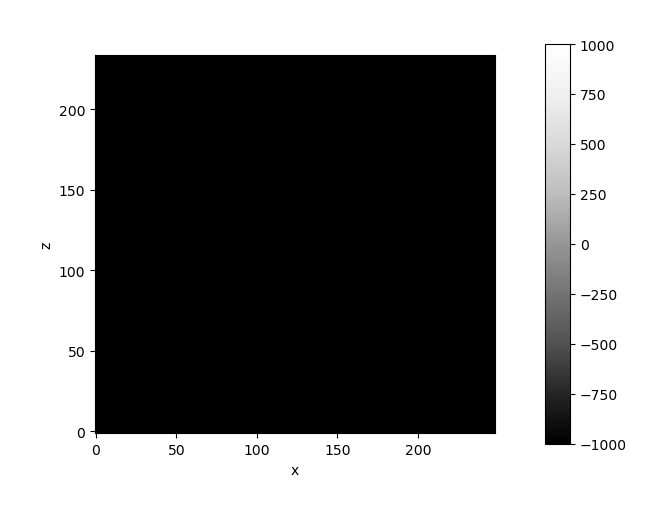

interactive(children=(SelectionSlider(description='phase', options=((0, 0), (10, 1), (20, 2), (30, 3), (40, 4)…

In [6]:
project.visual.view(case.anat + 1000*case.mask, x='x', y='z', cmap='Greys_r', vmin=-1000, vmax=1000)

In [10]:
%%time
mask = case.mask.sel(phase=0, roi='lung_combined_mask')
mesh = pygalmesh.generate_from_array(
    mask.values.astype(np.uint16),
    voxel_size=case.resolution,
    max_cell_circumradius=5.0, # mm
    odt=True
)
mesh = project.meshing.remove_unused_points(mesh)
mesh

CPU times: user 5.5 s, sys: 30.7 ms, total: 5.53 s
Wall time: 5.55 s


<meshio mesh object>
  Number of points: 15272
  Number of cells:
    triangle: 20676
    tetra: 75912

In [15]:
%autoreload

In [24]:
%%time
for case in emory4dct.cases:
    case.load_niftis()
    case.load_masks(roi='lung_combined_mask')
    for phase in emory4dct.phases:
        for radius in [5, 10, 20]:
            mask = case.mask.sel(phase=phase, roi='lung_combined_mask')
            mesh = pygalmesh.generate_from_array(
                mask.values.astype(np.uint16),
                voxel_size=case.resolution,
                max_cell_circumradius=float(radius), # mm
                odt=True
            )
            case.mesh_dir.mkdir(exist_ok=True)
            mesh_file = case.mesh_file(phase, radius)
            mesh_cells = [(mesh.cells[1].type, mesh.cells[1].data)]
            print(f'Saving {mesh_file}... {mesh.points.shape}')
            meshio.write_points_cells(mesh_file, mesh.points, mesh_cells)          
            

Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T00.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T10.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T20.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T30.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T40.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T50.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T60.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T70.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T80.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T90.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T00/lung_combined_mask.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T10/lung_combined_mask.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T20/lung_combined_mask.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T30/lung_combined_mask.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_

Loading ../data/Emory-4DCT/Case3Pack/TotalSegment/case3_T30/lung_combined_mask.nii.gz
Loading ../data/Emory-4DCT/Case3Pack/TotalSegment/case3_T40/lung_combined_mask.nii.gz
Loading ../data/Emory-4DCT/Case3Pack/TotalSegment/case3_T50/lung_combined_mask.nii.gz
Loading ../data/Emory-4DCT/Case3Pack/TotalSegment/case3_T60/lung_combined_mask.nii.gz
Loading ../data/Emory-4DCT/Case3Pack/TotalSegment/case3_T70/lung_combined_mask.nii.gz
Loading ../data/Emory-4DCT/Case3Pack/TotalSegment/case3_T80/lung_combined_mask.nii.gz
Loading ../data/Emory-4DCT/Case3Pack/TotalSegment/case3_T90/lung_combined_mask.nii.gz
Saving ../data/Emory-4DCT/Case3Pack/pygalmesh/case3_T00_5.xdmf... (25560, 3)
Saving ../data/Emory-4DCT/Case3Pack/pygalmesh/case3_T00_10.xdmf... (3610, 3)
Saving ../data/Emory-4DCT/Case3Pack/pygalmesh/case3_T00_20.xdmf... (535, 3)
Saving ../data/Emory-4DCT/Case3Pack/pygalmesh/case3_T10_5.xdmf... (25389, 3)
Saving ../data/Emory-4DCT/Case3Pack/pygalmesh/case3_T10_10.xdmf... (3618, 3)
Saving ../data

Saving ../data/Emory-4DCT/Case6Pack/pygalmesh/case6_T00_5.xdmf... (19701, 3)
Saving ../data/Emory-4DCT/Case6Pack/pygalmesh/case6_T00_10.xdmf... (2808, 3)
Saving ../data/Emory-4DCT/Case6Pack/pygalmesh/case6_T00_20.xdmf... (414, 3)
Saving ../data/Emory-4DCT/Case6Pack/pygalmesh/case6_T10_5.xdmf... (19389, 3)
Saving ../data/Emory-4DCT/Case6Pack/pygalmesh/case6_T10_10.xdmf... (2776, 3)
Saving ../data/Emory-4DCT/Case6Pack/pygalmesh/case6_T10_20.xdmf... (423, 3)
Saving ../data/Emory-4DCT/Case6Pack/pygalmesh/case6_T20_5.xdmf... (18114, 3)
Saving ../data/Emory-4DCT/Case6Pack/pygalmesh/case6_T20_10.xdmf... (2576, 3)
Saving ../data/Emory-4DCT/Case6Pack/pygalmesh/case6_T20_20.xdmf... (219, 3)
Saving ../data/Emory-4DCT/Case6Pack/pygalmesh/case6_T30_5.xdmf... (17368, 3)
Saving ../data/Emory-4DCT/Case6Pack/pygalmesh/case6_T30_10.xdmf... (2441, 3)
Saving ../data/Emory-4DCT/Case6Pack/pygalmesh/case6_T30_20.xdmf... (372, 3)
Saving ../data/Emory-4DCT/Case6Pack/pygalmesh/case6_T40_5.xdmf... (15976, 3)
Sav

Saving ../data/Emory-4DCT/Case8Deploy/pygalmesh/case8_T30_5.xdmf... (31119, 3)
Saving ../data/Emory-4DCT/Case8Deploy/pygalmesh/case8_T30_10.xdmf... (4353, 3)
Saving ../data/Emory-4DCT/Case8Deploy/pygalmesh/case8_T30_20.xdmf... (647, 3)
Saving ../data/Emory-4DCT/Case8Deploy/pygalmesh/case8_T40_5.xdmf... (29950, 3)
Saving ../data/Emory-4DCT/Case8Deploy/pygalmesh/case8_T40_10.xdmf... (4214, 3)
Saving ../data/Emory-4DCT/Case8Deploy/pygalmesh/case8_T40_20.xdmf... (642, 3)
Saving ../data/Emory-4DCT/Case8Deploy/pygalmesh/case8_T50_5.xdmf... (29220, 3)
Saving ../data/Emory-4DCT/Case8Deploy/pygalmesh/case8_T50_10.xdmf... (4086, 3)
Saving ../data/Emory-4DCT/Case8Deploy/pygalmesh/case8_T50_20.xdmf... (629, 3)
Saving ../data/Emory-4DCT/Case8Deploy/pygalmesh/case8_T60_5.xdmf... (28542, 3)
Saving ../data/Emory-4DCT/Case8Deploy/pygalmesh/case8_T60_10.xdmf... (4029, 3)
Saving ../data/Emory-4DCT/Case8Deploy/pygalmesh/case8_T60_20.xdmf... (608, 3)
Saving ../data/Emory-4DCT/Case8Deploy/pygalmesh/case8_T7

Saving ../data/Emory-4DCT/Case10Pack/pygalmesh/case10_T60_5.xdmf... (17883, 3)
Saving ../data/Emory-4DCT/Case10Pack/pygalmesh/case10_T60_10.xdmf... (2550, 3)
Saving ../data/Emory-4DCT/Case10Pack/pygalmesh/case10_T60_20.xdmf... (378, 3)
Saving ../data/Emory-4DCT/Case10Pack/pygalmesh/case10_T70_5.xdmf... (18157, 3)
Saving ../data/Emory-4DCT/Case10Pack/pygalmesh/case10_T70_10.xdmf... (2593, 3)
Saving ../data/Emory-4DCT/Case10Pack/pygalmesh/case10_T70_20.xdmf... (382, 3)
Saving ../data/Emory-4DCT/Case10Pack/pygalmesh/case10_T80_5.xdmf... (19195, 3)
Saving ../data/Emory-4DCT/Case10Pack/pygalmesh/case10_T80_10.xdmf... (2753, 3)
Saving ../data/Emory-4DCT/Case10Pack/pygalmesh/case10_T80_20.xdmf... (416, 3)
Saving ../data/Emory-4DCT/Case10Pack/pygalmesh/case10_T90_5.xdmf... (20199, 3)
Saving ../data/Emory-4DCT/Case10Pack/pygalmesh/case10_T90_10.xdmf... (2875, 3)
Saving ../data/Emory-4DCT/Case10Pack/pygalmesh/case10_T90_20.xdmf... (451, 3)
CPU times: user 15min 20s, sys: 11.3 s, total: 15min 31s